In [1]:
## PROCESSING LOGIC
## First download the station data for the Gulf States (TX, LA, AL, MS, FL)
## Then clip the stations to the watershed counties 
## Use the station names to build a URL and access the "narrow" sample results from the EPA Water Quality API

In [2]:
## RESOURCES

## EPA Water Quality Site:
## https://www.waterqualitydata.us/

## URL Examples
## Download all the stations for USA states FL, AL, TX, MS, LA as a GEOJSON:
## https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&statecode=US%3A12&statecode=US%3A48&statecode=US%3A28&statecode=US%3A22&mimeType=geojsonv&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET

## Download all the sample data for a given station (0800257-CC-05) as a CSV:
## https://www.waterqualitydata.us/data/Result/search?siteid=0800257-CC-05&mimeType=csv&zip=yes&dataProfile=narrowResult&providers=NWIS&providers=STEWARDS&providers=STORET

## CODE REFERENCE
## Arcpy Reference: https://developers.arcgis.com/python/api-reference/
## Time Sleep reference: https://stackoverflow.com/questions/72590954/how-to-add-the-time-sleep-after-every-100-iterations
## Time Sleep reference 2: https://stackoverflow.com/questions/72590954/how-to-add-the-time-sleep-after-every-100-iterations
## Enumerate in Python: https://realpython.com/python-enumerate/

In [3]:
#IMPORT LIBRARIES

import arcpy
import arcgis
from arcgis.gis import GIS
#from arcgis.mapping import WebMap
from datetime import datetime
from datetime import timedelta
import urllib.request
import os
import pandas
import glob
gis = GIS("home")
arcpy.env.overwriteOutput = True
arcgis.env.verbose = True 

In [4]:
## DEFINE VARIABLES

ROOT = r'C:\Temp\EPA-Water-Quality' #TODO Change to your preferred directory
TODAY = (datetime.today())
CURRENT_DATE = (TODAY.strftime('%Y%m%d'))
## Testing example for Baldwin County, Alabama:
WATER_QUALITY_STATIONS_URL = 'https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&countycode=US%3A01%3A003&mimeType=geojson&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET'
## All data for AL, FL, LA, MS, TX:
#WATER_QUALITY_STATIONS_URL = 'https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&statecode=US%3A12&statecode=US%3A22&statecode=US%3A28&statecode=US%3A48&mimeType=geojson&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET'
WORKING_DIRECTORY = ROOT + '\\working_' + str(CURRENT_DATE) + '\\'
WATER_QUALITY_STATIONS_DIRECTORY = WORKING_DIRECTORY + '\\stations\\'
WATER_QUALITY_STATIONS_ZIP = WATER_QUALITY_STATIONS_DIRECTORY + 'water_quality_stations.zip'
WORKING_STATIONS_JSON = WORKING_DIRECTORY + 'station.geojson'
WORKING_STATIONS_SHP  = WORKING_DIRECTORY + 'station.shp'
CLIPPED_STATIONS = WORKING_DIRECTORY + 'goma_stations.shp'
COASTAL_COUNTIES = WORKING_DIRECTORY + 'coastal_watershed_counties.shp'
CSV_WORKING_DIRECTORY = WORKING_DIRECTORY + 'csv\\'

In [5]:
if not os.path.exists(ROOT):
    os.makedirs(ROOT)
if not os.path.exists(WORKING_DIRECTORY):
    os.makedirs(WORKING_DIRECTORY)
if not os.path.exists(CSV_WORKING_DIRECTORY):
    os.makedirs(CSV_WORKING_DIRECTORY)
if not os.path.exists(WATER_QUALITY_STATIONS_DIRECTORY):
    os.makedirs(WATER_QUALITY_STATIONS_DIRECTORY)

<Item title:"coastal_watershed_counties_2010" type:Feature Layer Collection owner:kvangraafeiland_oceans>
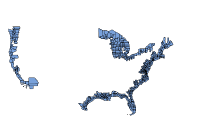

In [6]:
## Clip the stations to the specified polygon boundary 

## coastal_watershed_counties item id = ff61c0c5154d4791ae51f00c4e4a3a98
coastal_watershed_counties_item = gis.content.get('ff61c0c5154d4791ae51f00c4e4a3a98')
coastal_watershed_counties_item

In [7]:
coastal_watershed_counties_layer = coastal_watershed_counties_item.layers[0]
coastal_watershed_counties_layer

<FeatureLayer url:"https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/coastal_watershed_counties_2010/FeatureServer/0">

In [8]:
urllib.request.urlretrieve(WATER_QUALITY_STATIONS_URL, WATER_QUALITY_STATIONS_ZIP)

('C:\\Temp\\EPA-Water-Quality\\working_20230426\\\\stations\\water_quality_stations.zip',
 <http.client.HTTPMessage at 0x1d6eb823190>)

In [9]:
import zipfile
with zipfile.ZipFile(WATER_QUALITY_STATIONS_ZIP, 'r') as zip_ref:
    zip_ref.extractall(WORKING_DIRECTORY)

In [10]:
arcpy.conversion.JSONToFeatures(WORKING_STATIONS_JSON, WORKING_STATIONS_SHP, geometry_type="POINT")

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230426\\station.shp'>

In [11]:
arcpy.analysis.PairwiseDissolve(
    in_features="https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/coastal_watershed_counties_2010/FeatureServer/0",
    out_feature_class=COASTAL_COUNTIES,
    dissolve_field=None,
    statistics_fields=None,
    multi_part="MULTI_PART",
    concatenation_separator=""
)

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230426\\coastal_watershed_counties.shp'>

In [12]:
arcpy.analysis.Clip(WORKING_STATIONS_SHP, COASTAL_COUNTIES, CLIPPED_STATIONS)

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230426\\goma_stations.shp'>

In [13]:
arcpy.management.CalculateGeometryAttributes(CLIPPED_STATIONS, [["X", "POINT_X"], ["Y", "POINT_Y"]])

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230426\\goma_stations.shp'>

In [14]:
stations_df = pandas.DataFrame.spatial.from_featureclass(CLIPPED_STATIONS)
stations_df.set_index('Monitoring')
stations_df.head()

,FID,ProviderNa,Organizati,Organiza_1,Monitoring,Monitori_1,Monitori_2,ResolvedMo,HUCEightDi,siteUrl,activityCo,resultCoun,StateName,CountyName,X,Y,SHAPE
0,0,NWIS,USGS-AL,USGS Alabama Water Science Center,USGS-02376240,"DYAS CREEK AT US HWY 31 NEAR DYAS, AL.",Stream,Stream,03140106,https://www.waterqualitydata.us/provider/NWIS/...,2,51,Alabama,Baldwin County,-87.684989,30.933517,"{""x"": -87.6849889, ""y"": 30.933517, ""z"": 0, ""m""..."
1,1,NWIS,USGS-AL,USGS Alabama Water Science Center,USGS-02376245,MCCURTIN CREEK NEAR BAY MINETTE AL,Stream,Stream,03140106,https://www.waterqualitydata.us/provider/NWIS/...,1,12,Alabama,Baldwin County,-87.723046,30.909073,"{""x"": -87.7230458, ""y"": 30.9090732, ""z"": 0, ""m..."
2,2,NWIS,USGS-AL,USGS Alabama Water Science Center,USGS-02376250,"DYAS CREEK AT CO RD 61 NEAR BAY MINETTE, AL.",Stream,Stream,03140106,https://www.waterqualitydata.us/provider/NWIS/...,0,0,Alabama,Baldwin County,-87.639987,30.870186,"{""x"": -87.6399873, ""y"": 30.8701856, ""z"": 0, ""m..."
3,3,NWIS,USGS-AL,USGS Alabama Water Science Center,USGS-02377200,STYX RIVER NEAR STAPLETON AL,Stream,Stream,03140106,https://www.waterqualitydata.us/provider/NWIS/...,1,12,Alabama,Baldwin County,-87.729157,30.738245,"{""x"": -87.7291567, ""y"": 30.7382448, ""z"": 0, ""m..."
4,4,NWIS,USGS-AL,USGS Alabama Water Science Center,USGS-02377300,"STYX RIVER AT BRADY ROAD BELOW STAPLETON, AL.",Stream,Stream,03140106,https://www.waterqualitydata.us/provider/NWIS/...,23,323,Alabama,Baldwin County,-87.706656,30.691302,"{""x"": -87.7066557, ""y"": 30.6913015, ""z"": 0, ""m..."


In [15]:
for col in stations_df.columns:
    print(col)

FID
ProviderNa
Organizati
Organiza_1
Monitoring
Monitori_1
Monitori_2
ResolvedMo
HUCEightDi
siteUrl
activityCo
resultCoun
StateName
CountyName
X
Y
SHAPE


In [16]:
# let's use the station list to get the sample data for each station

valueList = []  # array to hold list of values collected
valueSet = set()  # set to hold values to test against to get list
rows = arcpy.SearchCursor(WORKING_STATIONS_SHP)
field = "Monitoring"
index = 0
for row in rows:
    value = row.getValue(field)
    print(index, row)
    index += 1
    if index % 1000 == 0:
        time.sleep(60)
        print("60-second pause.....")
    print('Processing Station ' + value)
    old_file = os.path.join(CSV_WORKING_DIRECTORY, 'narrowresult.csv')
    new_file = os.path.join(CSV_WORKING_DIRECTORY, value +'.csv')
    sample_data_zip = CSV_WORKING_DIRECTORY + str(value) + '_' + CURRENT_DATE + '_sample_narrow.zip'
    station_narrow_url = 'https://www.waterqualitydata.us/data/Result/search?siteid=' + value + '&mimeType=csv&zip=yes&dataProfile=narrowResult&providers=NWIS&providers=STEWARDS&providers=STORET'
    urllib.request.urlretrieve(station_narrow_url, sample_data_zip)
    with zipfile.ZipFile(sample_data_zip, 'r') as zip_ref:
        zip_ref.extractall(CSV_WORKING_DIRECTORY)
    os.rename(old_file, new_file)
    os.remove(sample_data_zip)
    sample_df = pandas.read_csv(new_file)
    sample_df.rename(columns={'MonitoringLocationIdentifier':'Monitoring'}, inplace=True)
    sample_df.set_index('Monitoring')
    result = pandas.merge(sample_df, stations_df, how='left')
    result.drop(columns=['FID','SHAPE'], inplace=True)
    result.to_csv(new_file)

0 <geoprocessing row object object at 0x000001D6EB019C90>
Processing Station USGS-02376240
1 <geoprocessing row object object at 0x000001D6EB019CF0>
Processing Station USGS-02376245
2 <geoprocessing row object object at 0x000001D6EB019D90>
Processing Station USGS-02376250
3 <geoprocessing row object object at 0x000001D6EB0195D0>
Processing Station USGS-02377200
4 <geoprocessing row object object at 0x000001D6ED544830>
Processing Station USGS-02377300
5 <geoprocessing row object object at 0x000001D6ED544890>
Processing Station USGS-02377500
6 <geoprocessing row object object at 0x000001D6F14A97D0>
Processing Station USGS-02377505
7 <geoprocessing row object object at 0x000001D6F14A9D30>
Processing Station USGS-02377540
8 <geoprocessing row object object at 0x000001D6F14A91F0>
Processing Station USGS-02377550
9 <geoprocessing row object object at 0x000001D6F14A9C10>
Processing Station USGS-02377560
10 <geoprocessing row object object at 0x000001D6ED544890>
Processing Station USGS-0237757

C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (10,60,62,63,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


827 <geoprocessing row object object at 0x000001D6F15CB5B0>
Processing Station 21AWIC-1098
828 <geoprocessing row object object at 0x000001D6F1599D90>
Processing Station 21AWIC-11107
829 <geoprocessing row object object at 0x000001D6F1599F50>
Processing Station 21AWIC-1122
830 <geoprocessing row object object at 0x000001D6F1599A90>
Processing Station 21AWIC-1125
831 <geoprocessing row object object at 0x000001D6F1599F10>
Processing Station 21AWIC-1126
832 <geoprocessing row object object at 0x000001D6F14A9BD0>
Processing Station 21AWIC-11370
833 <geoprocessing row object object at 0x000001D6F14A9770>
Processing Station 21AWIC-1152
834 <geoprocessing row object object at 0x000001D6F14A9050>
Processing Station 21AWIC-1159
835 <geoprocessing row object object at 0x000001D6F14A9C90>
Processing Station 21AWIC-1186
836 <geoprocessing row object object at 0x000001D6F15B9250>
Processing Station 21AWIC-1203
837 <geoprocessing row object object at 0x000001D6F15B9CB0>
Processing Station 21AWIC-12

C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (10,62,63,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


851 <geoprocessing row object object at 0x000001D685F5FD90>
Processing Station 21AWIC-1282


C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


852 <geoprocessing row object object at 0x000001D6F26BC030>
Processing Station 21AWIC-1283
853 <geoprocessing row object object at 0x000001D6F14A95F0>
Processing Station 21AWIC-1299
854 <geoprocessing row object object at 0x000001D6F14A90F0>
Processing Station 21AWIC-1300
855 <geoprocessing row object object at 0x000001D6F14A93F0>
Processing Station 21AWIC-1301
856 <geoprocessing row object object at 0x000001D6F14A9BD0>
Processing Station 21AWIC-1302
857 <geoprocessing row object object at 0x000001D6F26BCB10>
Processing Station 21AWIC-1303
858 <geoprocessing row object object at 0x000001D6F26BC450>
Processing Station 21AWIC-1466
859 <geoprocessing row object object at 0x000001D6F26BCDB0>
Processing Station 21AWIC-1503
860 <geoprocessing row object object at 0x000001D6F26BCE10>
Processing Station 21AWIC-1542
861 <geoprocessing row object object at 0x000001D6F26BCA70>
Processing Station 21AWIC-1573
862 <geoprocessing row object object at 0x000001D6ED544850>
Processing Station 21AWIC-1605

C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


887 <geoprocessing row object object at 0x000001D6F2660F90>
Processing Station 21AWIC-2508
888 <geoprocessing row object object at 0x000001D68642EFD0>
Processing Station 21AWIC-2531
889 <geoprocessing row object object at 0x000001D68642E3F0>
Processing Station 21AWIC-2687
890 <geoprocessing row object object at 0x000001D68642E550>
Processing Station 21AWIC-2688
891 <geoprocessing row object object at 0x000001D68642E570>
Processing Station 21AWIC-2689
892 <geoprocessing row object object at 0x000001D68642ED50>
Processing Station 21AWIC-2690
893 <geoprocessing row object object at 0x000001D68642E7D0>
Processing Station 21AWIC-2691
894 <geoprocessing row object object at 0x000001D68642EEB0>
Processing Station 21AWIC-2714
895 <geoprocessing row object object at 0x000001D6EB019AB0>
Processing Station 21AWIC-2724
896 <geoprocessing row object object at 0x000001D6EB019BD0>
Processing Station 21AWIC-2730


C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (9,20,71) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


897 <geoprocessing row object object at 0x000001D6F267CE90>
Processing Station 21AWIC-2797
898 <geoprocessing row object object at 0x000001D685F5FE10>
Processing Station 21AWIC-2841
899 <geoprocessing row object object at 0x000001D685F5F310>
Processing Station 21AWIC-2842
900 <geoprocessing row object object at 0x000001D685F5F2F0>
Processing Station 21AWIC-2858
901 <geoprocessing row object object at 0x000001D685F5F4F0>
Processing Station 21AWIC-2942
902 <geoprocessing row object object at 0x000001D685F5FAD0>
Processing Station 21AWIC-2994
903 <geoprocessing row object object at 0x000001D685F5FC10>
Processing Station 21AWIC-3026
904 <geoprocessing row object object at 0x000001D685F5F9B0>
Processing Station 21AWIC-3070
905 <geoprocessing row object object at 0x000001D685F5F990>
Processing Station 21AWIC-3158
906 <geoprocessing row object object at 0x000001D685F5FD90>
Processing Station 21AWIC-3229
907 <geoprocessing row object object at 0x000001D685F5F870>
Processing Station 21AWIC-3269

C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


963 <geoprocessing row object object at 0x000001D6863CDE10>
Processing Station 21AWIC-5531
964 <geoprocessing row object object at 0x000001D6EB019BD0>
Processing Station 21AWIC-5550
965 <geoprocessing row object object at 0x000001D68642E710>
Processing Station 21AWIC-581
966 <geoprocessing row object object at 0x000001D68642E350>
Processing Station 21AWIC-582
967 <geoprocessing row object object at 0x000001D68642EE10>
Processing Station 21AWIC-615
968 <geoprocessing row object object at 0x000001D68642EA50>
Processing Station 21AWIC-620
969 <geoprocessing row object object at 0x000001D68642EC70>
Processing Station 21AWIC-6890
970 <geoprocessing row object object at 0x000001D68642E470>
Processing Station 21AWIC-6891
971 <geoprocessing row object object at 0x000001D68642E190>
Processing Station 21AWIC-6892
972 <geoprocessing row object object at 0x000001D68642E410>
Processing Station 21AWIC-6893
973 <geoprocessing row object object at 0x000001D68642E430>
Processing Station 21AWIC-6910
974

C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (17,60) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


984 <geoprocessing row object object at 0x000001D686980F90>
Processing Station 21AWIC-7190
985 <geoprocessing row object object at 0x000001D686414EF0>
Processing Station 21AWIC-7241
986 <geoprocessing row object object at 0x000001D686414B70>
Processing Station 21AWIC-7290
987 <geoprocessing row object object at 0x000001D6EB019BD0>
Processing Station 21AWIC-7310
988 <geoprocessing row object object at 0x000001D686414610>
Processing Station 21AWIC-7311
989 <geoprocessing row object object at 0x000001D686414310>
Processing Station 21AWIC-761
990 <geoprocessing row object object at 0x000001D6864145F0>
Processing Station 21AWIC-763
991 <geoprocessing row object object at 0x000001D686414E30>
Processing Station 21AWIC-7650
992 <geoprocessing row object object at 0x000001D686414990>
Processing Station 21AWIC-7651
993 <geoprocessing row object object at 0x000001D686414F10>
Processing Station 21AWIC-7652
994 <geoprocessing row object object at 0x000001D686414730>
Processing Station 21AWIC-7653
9

C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\1842683643.py:24: DtypeWarning: Columns (17,60) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


1004 <geoprocessing row object object at 0x000001D686414B30>
Processing Station 21AWIC-9280
1005 <geoprocessing row object object at 0x000001D6F14A90F0>
Processing Station 21AWIC-9283
1006 <geoprocessing row object object at 0x000001D6F15B9BB0>
Processing Station 21AWIC-9284
1007 <geoprocessing row object object at 0x000001D6F15B9A10>
Processing Station 21AWIC-9320
1008 <geoprocessing row object object at 0x000001D6F14A9610>
Processing Station 21AWIC-942
1009 <geoprocessing row object object at 0x000001D6F14A9450>
Processing Station 21AWIC-9528
1010 <geoprocessing row object object at 0x000001D6F26606B0>
Processing Station 21AWIC-9609
1011 <geoprocessing row object object at 0x000001D6F2660EF0>
Processing Station 21AWIC-9630
1012 <geoprocessing row object object at 0x000001D6F26607F0>
Processing Station 21AWIC-9631
1013 <geoprocessing row object object at 0x000001D6F2660DD0>
Processing Station 21AWIC-9766
1014 <geoprocessing row object object at 0x000001D6F2660DB0>
Processing Station 2

In [17]:
# now let's merge all the CSV files into one

SAMPLE_NARROW_MERGED_CSV = CSV_WORKING_DIRECTORY + "All_GOMA_Sample_Narrow_Results.csv"
joined_files = os.path.join(CSV_WORKING_DIRECTORY, "*.csv")
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
# Finally, the files are joined
GOMA_NAROW_STATIONS_MERGED = pandas.concat(map(pandas.read_csv, joined_list), ignore_index=True)
GOMA_NAROW_STATIONS_MERGED.to_csv(SAMPLE_NARROW_MERGED_CSV, index=False)

C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\3856583867.py:8: DtypeWarning: Columns (11,61,63,64,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  GOMA_NAROW_STATIONS_MERGED = pandas.concat(map(pandas.read_csv, joined_list), ignore_index=True)
C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\3856583867.py:8: DtypeWarning: Columns (11,63,64,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  GOMA_NAROW_STATIONS_MERGED = pandas.concat(map(pandas.read_csv, joined_list), ignore_index=True)
C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\3856583867.py:8: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  GOMA_NAROW_STATIONS_MERGED = pandas.concat(map(pandas.read_csv, joined_list), ignore_index=True)
C:\Users\keit8223\AppData\Local\Temp\5\ipykernel_19940\3856583867.py:8: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set

In [18]:
# now let's create a shpaefile from the merged CSV file

SHAPEFILE_NAME = 'sample_stations'
SAMPLE_STATIONS_SHP = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME + '.shp'
SAMPLE_STATIONS = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME

arcpy.management.XYTableToPoint(
    in_table=SAMPLE_NARROW_MERGED_CSV,
    out_feature_class=SAMPLE_STATIONS_SHP,
    x_field="X",
    y_field="Y",
    z_field=None,
    coordinate_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision'
)

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230426\\csv\\sample_stations.shp'>

In [19]:
# now let's zip the shapefile so we can publish to arcgis online

ZIPFILE_LOCATION = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME + '.zip'

shapefiles_list = [SAMPLE_STATIONS + ".cpg",
                   SAMPLE_STATIONS + ".dbf",
                   SAMPLE_STATIONS + ".prj",
                   SAMPLE_STATIONS + ".sbn",
                   SAMPLE_STATIONS + ".sbx",
                   SAMPLE_STATIONS + ".shp",
                   SAMPLE_STATIONS + ".shp.xml",
                   SAMPLE_STATIONS + ".shx"]
with zipfile.ZipFile(ZIPFILE_LOCATION, 'w') as zipMe:        
    for file in shapefiles_list:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)